In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
%autosave 180
%matplotlib inline

Autosaving every 180 seconds


## Table Of Content:
* [Data Cleaning](#first-bullet)
* [Feature Engineering](#second-bullet)
* [K-Means Modeling](#third-bullet)
    * [Elbow Iteration](#fourth-bullet)
    * [7-Cluster Model](#fifth-bullet)
    * [Discussion](#sixth-bullet)

# Data Cleaning <a class="anchor" id="first-bullet"></a>

In [2]:
data = pd.read_csv("/Users/aston/Desktop/CU2020Summer/M5/inpatientCharges.csv")

In [3]:
#gets rid of the white space on both the left and right of each column
data.columns = data.columns.str.lstrip()
data.columns = data.columns.str.rstrip()
#changes the dtype of some columns into floats
data['Average Covered Charges']= data['Average Covered Charges'].replace('[\$,]', '', regex=True).astype(float)
data['Average Total Payments']= data['Average Total Payments'].replace('[\$,]', '', regex=True).astype(float)
data['Average Medicare Payments']= data['Average Medicare Payments'].replace('[\$,]', '', regex=True).astype(float)
# calculate the amount of copy or 'out of pocket' cost to individual
data['Average Copay']= data['Average Total Payments'] - data['Average Medicare Payments']


In [4]:
# see the number of unique values in each column 
l1 = []
for col in data.columns:
    l1.append(data[col].unique().shape[0])
l2 = data.columns.tolist()
uniquedf = pd.DataFrame({'Column' : l2,
                        'UniqueCount' : l1 },
                        columns=['Column','UniqueCount'])
uniquedf.head() #decided to use Provider Id as the unique ID because it is the most granular

,Column,UniqueCount
0,DRG Definition,100
1,Provider Id,3337
2,Provider Name,3201
3,Provider Street Address,3326
4,Provider City,1977


# Feature Enginerring <a class="anchor" id="second-bullet"></a>

## Simple Features

In [5]:
# This variable I created will consider anomalies in both Copay and Medicare payments.
# This variable also excludes the noise that comes from different hospital charge structures. 
# It only considers the actual payment.
data['Total Payments']= data['Total Discharges']*data['Average Total Payments']
data['Medicare Coverage'] = data['Average Medicare Payments'] / data['Average Total Payments']

# Feature 1: Calculate the "Precise Average Total Payments by DRG by State", use the simple standard deviation as the proxy, then encode a column whther an observation is outside of the 95% of the data sample, or 2 standard deviation away from the mean.

### Ran into a problem
To be precise, the standard deviation should have been calculated as the following:
1. Duplicate the each row based on the number on "Total Discharges"
2. Then groupby 'DRG' and 'State'
3. Then calculate the standard deviation
4. Then append it back to the main dataframe to calculate confidence interval
5. But std['Total Discharges'].sum() = 6,975,318 here are 7 million records, and my kernel died
6. Hypothetical code: <br>
std = std.loc[std.index.repeat(std['Average Total Payments'])] <br>
std = std.groupby(['DRG Definition','State']).ddescribe() <br>
pd.merge(data, std, on=['DRG Definition','Provider State']) 

As a result of the above approach, I use the simple standard deviation as the proxy to calcualte the confidence interval. <br>
The empirical rule states that 95% of the distribution lies within two standard deviations. 


In [6]:
data.sort_values(by=['DRG Definition']).head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,525728.84,0.824568
711,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,340017,MARGARET R PARDEE MEMORIAL HOSPITAL,800 N JUSTICE ST,HENDERSONVILLE,NC,28791,NC - Asheville,19,17132.63,5787.15,4959.78,827.37,109955.85,0.857033
712,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,340027,LENOIR MEMORIAL HOSPITAL,100 AIRPORT RD,KINSTON,NC,28501,NC - Greenville,22,19897.40,6421.45,4993.00,1428.45,141271.90,0.777550
713,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,340028,CAPE FEAR VALLEY MEDICAL CENTER,1638 OWEN DRIVE P O BOX 2000,FAYETTEVILLE,NC,28302,NC - Raleigh,69,24250.44,7044.68,5907.13,1137.55,486082.92,0.838524
714,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,340030,DUKE UNIVERSITY HOSPITAL,PO BOX 3708 DUMC ERWIN RD,DURHAM,NC,27710,NC - Durham,38,23353.18,8708.86,7849.18,859.68,330936.68,0.901287


In [7]:
# mean total payment by state, by drg. Map it back to the original data, groupby provider ID, calcualte a ratio 
meanpaymentbenchmark = data.groupby(
    ["DRG Definition",'Provider State'])['Total Payments'].sum()/data.groupby(
    ["DRG Definition",'Provider State'])['Total Discharges'].sum()
meanpaymentbenchmark.head()

DRG Definition                            Provider State
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AK                8401.950000
                                          AL                5857.170580
                                          AR                5932.607653
                                          AZ                7034.478416
                                          CA                8251.965364
dtype: float64

In [8]:
meanpaymentbenchmark = pd.DataFrame(data = meanpaymentbenchmark)
meanpaymentbenchmark.reset_index(inplace=True)
meanpaymentbenchmark.rename(columns={0:'AverageTotal PaymentDRGState'},inplace=True)
meanpaymentbenchmark.head()

,DRG Definition,Provider State,AverageTotal PaymentDRGState
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AK,8401.950000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL,5857.170580
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AR,5932.607653
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AZ,7034.478416
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,CA,8251.965364


In [9]:
# fill na with value of 0, if there's only one observation, the std is 0.
df2 = data.copy()
df2 = df2.groupby(['DRG Definition','Provider State'])['Average Total Payments'].describe()
df2['std'].fillna(value=0, inplace=True)
df2.isnull().values.any()
meanpaymentbenchmark = pd.merge(meanpaymentbenchmark, df2, on=['DRG Definition','Provider State'])
meanpaymentbenchmark.head()

,DRG Definition,Provider State,AverageTotal PaymentDRGState,count,mean,std,min,25%,50%,75%,max
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AK,8401.950000,1.0,8401.950000,0.000000,8401.95,8401.9500,8401.95,8401.9500,8401.95
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL,5857.170580,23.0,5743.611739,628.702608,4968.00,5396.1050,5658.33,5882.4250,8031.12
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AR,5932.607653,16.0,6118.828750,1059.463235,5225.59,5558.5000,5890.00,6174.4650,9838.11
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AZ,7034.478416,24.0,7271.555833,1283.210551,5976.00,6452.8625,6959.89,7697.0975,11026.33
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,CA,8251.965364,67.0,8387.932687,1807.867216,6390.25,7194.3500,7863.14,8811.2200,16744.82


Code on how to display groupby object
df1 = data.groupby('Provider Id')
df1 = df1.apply(lambda x: x).copy()
type(df1)

In [10]:
# merge the benchmark to the original data
df1 = pd.merge(data, meanpaymentbenchmark, on=['DRG Definition','Provider State'])
df1.drop(columns=['count', 'mean'], inplace=True)
df1.shape

(163065, 22)

In [11]:
# the n for each DRG State
ndf = data.copy()
ndf = pd.DataFrame(data = ndf.groupby(['DRG Definition', 'Provider State'])['Total Discharges'].count())
ndf.rename(columns={'Total Discharges':'n'}, inplace=True)
df1 = pd.merge(df1, ndf, on=['DRG Definition','Provider State'])
df1.shape

(163065, 23)

In [12]:
# # dumbway to do it, 95% z score is 1.96
# df1['lower'] = df1['AverageTotal PaymentDRGState'] - 1.96*df1['std']/(df1['n']**(0.5))
# df1['upper'] = df1['AverageTotal PaymentDRGState'] + 1.96*df1['std']/(df1['n']**(0.5))
# df1.columns

In [13]:
def confint(mean, std, n, data):
    hi = mean + 1.96*std 
    lo = mean - 1.96*std 
    if data > hi:
        return 1
    elif data < lo:
        return 1
    else:
        return 0 

In [44]:
# run the outlier test, flag when the record is 2 std away from the mean
df1['Average TP Anomaly'] = df1.apply(lambda x: 
          confint(x['AverageTotal PaymentDRGState'], x['std'], x['n'], x['Average Total Payments']), 
          axis = 1)
data['Average TP Anomaly'] = df1['Average TP Anomaly']


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,525728.84,0.824568,0,0.986353,0,2.381115,0.801778
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,81025.98,0.859896,0,0.988117,0,0.366325,0.801778
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,130438.80,0.819472,0,0.927914,0,0.627986,0.801778
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,135439.00,0.762181,0,0.924945,0,0.654152,0.801778
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,101849.94,0.857398,0,0.966052,0,0.470990,0.801778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,87557.78,0.806804,0,1.308997,1,2.663237,0.779579
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,44300.96,0.657930,0,1.025923,0,1.021515,0.779579
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,108382.84,0.711449,0,1.092923,0,0.782609,0.749232
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,84293.99,0.893705,0,0.982432,0,1.239130,0.749232


# Feature 2:  "Average Total Payments" /  "Precise Average Total Payments by DRG by State" 

In [15]:
df1.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments', 'Average Copay', 'Total Payments',
       'Medicare Coverage', 'AverageTotal PaymentDRGState', 'std', 'min',
       '25%', '50%', '75%', 'max', 'n', 'Average TP Anomaly'],
      dtype='object')

In [16]:
df1['Average TP Ratio'] = df1['Average Total Payments'] / df1['AverageTotal PaymentDRGState']
data['Average TP Ratio'] = df1['Average TP Ratio']

# Feature 3: Calculate the "Precise Average Total Discharges by DRG by State". Merge the benchmark to the original dataset, then encode a column whther an observation is outside of the 95% of the data sample, or 2 standard deviation away from the mean. 

In [17]:
# calculate the benchmark total charges by DRG by State
f2 = data.groupby(['DRG Definition', 'Provider State'])['Total Discharges'].describe()
f2.fillna(0, inplace=True)
f2 = pd.merge(data, f2, on=['DRG Definition', 'Provider State'])
f2.rename(columns={'mean':'benchmark'}, inplace=True)

In [18]:
# flag when the record is 2 std away from the benchmark mean
f2['Average TD Anomaly'] = f2.apply(lambda x: 
                                    confint(x['benchmark'],x['std'],x['count'],x['Total Discharges']),
                                    axis=1)
data['Average TD Anomaly'] = f2['Average TD Anomaly']

## Example of confidence interval with total discharges


In [19]:
data['Total Discharges']

0         91
1         14
2         24
3         25
4         18
          ..
163060    23
163061    11
163062    19
163063    11
163064    12
Name: Total Discharges, Length: 163065, dtype: int64

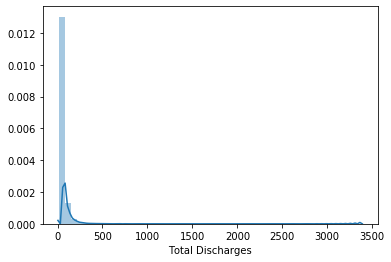

In [20]:
sns.distplot(data['Total Discharges']);

In [21]:
data['Total Discharges'].describe()

count    163065.000000
mean         42.776304
std          51.104042
min          11.000000
25%          17.000000
50%          27.000000
75%          49.000000
max        3383.000000
Name: Total Discharges, dtype: float64

In [22]:
data1 = data.copy()
data1['mean'] = 42.776304
data1['std'] = 51.104
data1['n'] = 163065

In [23]:
data1.apply(lambda x: confint(x['mean'], x['std'], x['n'], x['Total Discharges']), axis=1).sum()

5925

# Feature 4: "Total Discharge" / "Average Total Discharges by DRG by State"

In [24]:
# calcualte a ratio as mentioned above
f2['Avearge TD Ratio'] = f2['Total Discharges'] / f2['benchmark']

In [25]:
data['Average TD Ratio'] = f2['Avearge TD Ratio']

# Feature 5: Medicare Coverage = Medicare Payment / Total Payment; Groupby DRG and Provider State to get the mean "Medicare Coverage". Compare each record's medicare coverage to the benchmark coverage.

In [26]:
f5 = data.copy()
f5 = f5.groupby(['DRG Definition', 'Provider State'])['Medicare Coverage'].describe()['mean']
f5 = pd.merge(data, f5, on=['DRG Definition', 'Provider State'])
f5.rename(columns={'mean':'Medicare Coverage Ratio'}, inplace=True)
data['Medicare Coverage Ratio'] = f5['Medicare Coverage Ratio']

# K-Means Modeling <a class="anchor" id="third-bullet"></a>

In [27]:
# create a copy of the data and drop categorical columns
x = data.copy()
x['DRG Definition'] = x['DRG Definition'].str.extract('(\d+)')
x.drop(columns=['Provider Id', 'Provider Name', 'Provider Street Address', 
                'Provider City', 'Provider State','Hospital Referral Region Description',
                'DRG Definition', 'Provider Zip Code'], inplace=True)
y = x.copy()
x.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio
0,91,32963.07,5777.24,4763.73,1013.51,525728.84,0.824568,0,0.986353,0,2.381115,0.801778
1,14,15131.85,5787.57,4976.71,810.86,81025.98,0.859896,0,0.988117,0,0.366325,0.801778
2,24,37560.37,5434.95,4453.79,981.16,130438.80,0.819472,0,0.927914,0,0.627986,0.801778
3,25,13998.28,5417.56,4129.16,1288.40,135439.00,0.762181,0,0.924945,0,0.654152,0.801778
4,18,31633.27,5658.33,4851.44,806.89,101849.94,0.857398,0,0.966052,0,0.470990,0.801778


In [28]:
# scale the data, return the column names
x = scale(x)
x = pd.DataFrame(x, columns=y.columns)
x.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio
0,0.943640,-0.090428,-0.512776,-0.510403,-0.173743,0.177089,-0.249983,-0.225655,-0.018265,-0.230225,2.013039,-0.727008
1,-0.563094,-0.598943,-0.511428,-0.481265,-0.350253,-0.497424,0.151875,-0.225655,-0.009206,-0.230225,-0.923610,-0.727008
2,-0.367414,0.040679,-0.557435,-0.552805,-0.201920,-0.422476,-0.307955,-0.225655,-0.318422,-0.230225,-0.542227,-0.727008
3,-0.347846,-0.631271,-0.559703,-0.597218,0.065689,-0.414892,-0.959650,-0.225655,-0.333671,-0.230225,-0.504089,-0.727008
4,-0.484822,-0.128352,-0.528290,-0.498403,-0.353710,-0.465839,0.123455,-0.225655,-0.122538,-0.230225,-0.771057,-0.727008


### Elbow Iteration <a class="anchor" id="fourth-bullet"></a>

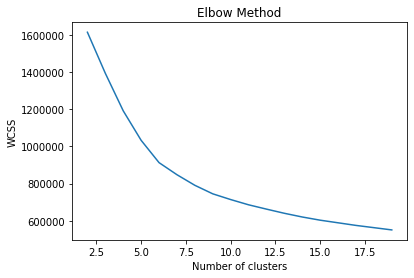

In [29]:
# iterate the kmeans algorithm between k=2 to k=20 times, see the elbow chart
wcss = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Although it was suggested to limit the number k around 5-10. According to my model, the Elbow Chart shows that the diminishing return starts around 7. That is when the slope of the line changes the most. As a result, I picked 7 for my following analysis.

### 7-Cluster Model <a class="anchor" id="fifth-bullet"></a>

In [30]:
# compute kmeans when k=7
kmeans = KMeans(n_clusters=7, random_state=0).fit(x)
kfit = kmeans.fit(x)
identified_clusters = kfit.predict(x)

In [31]:
# map the cluster number back to the original table
clustered_data = data.copy()
clustered_data['Cluster'] = identified_clusters
clustered_data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4763.73,1013.51,525728.84,0.824568,0,0.986353,0,2.381115,0.801778,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4976.71,810.86,81025.98,0.859896,0,0.988117,0,0.366325,0.801778,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4453.79,981.16,130438.80,0.819472,0,0.927914,0,0.627986,0.801778,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,4129.16,1288.40,135439.00,0.762181,0,0.924945,0,0.654152,0.801778,0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4851.44,806.89,101849.94,0.857398,0,0.966052,0,0.470990,0.801778,0


In [32]:
# compute a dataframe for the count and percentage of the 7-Cluster Model
numbercluster = pd.DataFrame(clustered_data.groupby('Cluster')['Provider Id'].describe()['count'])
numbercluster['percent'] = numbercluster['count'] / numbercluster['count'].sum()
numbercluster.sort_values(by='percent')

,count,percent
Cluster,,
4,2731.0,0.016748
5,2990.0,0.018336
6,7309.0,0.044823
3,7411.0,0.045448
2,7711.0,0.047288
0,65695.0,0.402876
1,69218.0,0.424481


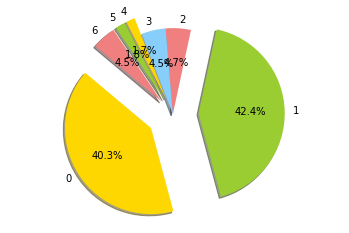

In [33]:
# Data to plot
labels = numbercluster.index
sizes = numbercluster['count']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.3, 0.3, 0, 0, 0.2, 0.2 , 0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [34]:
# slice the dataframe and add the 'count' column
analysis = clustered_data.groupby('Cluster')['Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments', 'Average Copay', 'Total Payments',
       'Medicare Coverage', 'Average TP Anomaly', 'Average TP Ratio',
       'Average TD Anomaly', 'Average TD Ratio', 'Medicare Coverage Ratio',
       'Cluster'].describe()
idx = pd.IndexSlice
analysis = analysis.loc[:, idx[ : , ['mean']]]
analysis.insert(0,column='count', value=numbercluster['count'].tolist())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [35]:
analysis.sort_values(by='count')

,count,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,
4,2731.0,30.751007,86711.626873,24711.444749,17582.180029,7129.264720,7.514986e+05,0.689939,0.032589,1.003801,0.021604,0.921745,0.887545,4.0
5,2990.0,282.590301,45479.319124,13028.800054,11386.244084,1642.555970,3.532437e+06,0.867220,0.023411,0.990324,0.035786,1.013959,0.869794,5.0
6,7309.0,40.014639,33882.690077,9486.007846,8259.624541,1226.383306,3.730803e+05,0.847311,0.999590,1.528558,0.019018,0.905914,0.841622,6.0
3,7411.0,28.430711,133884.411186,34360.085195,32756.627942,1603.457253,9.627929e+05,0.951243,0.026447,0.973922,0.025907,0.951227,0.920750,3.0
2,7711.0,57.053430,32472.224806,8796.509959,7653.326037,1143.183922,4.719096e+05,0.844172,0.030476,1.024874,1.000000,2.971465,0.843650,2.0
0,65695.0,36.936951,20051.222375,5387.024679,4247.101273,1139.923406,1.994093e+05,0.784551,0.000015,0.957665,0.000000,0.897664,0.797397,0.0
1,69218.0,38.670765,39178.628333,10557.945199,9563.051301,994.893898,3.969195e+05,0.899643,0.000058,0.960886,0.000000,0.895145,0.883467,1.0


### Discussion <a class="anchor" id="sixth-bullet"></a>

In [36]:
analysis.iloc[4:5 , :]

,count,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,
4,2731.0,30.751007,86711.626873,24711.444749,17582.180029,7129.26472,751498.625079,0.689939,0.032589,1.003801,0.021604,0.921745,0.887545,4.0


#### Cluster 4
As seen from the pie-chart above, Cluster 4 accounts for 1.7% of the total number of data, which includes about 2731 rows of observations. For this cluster, the "Total Discharges" is 30.7, which is near the low end of the specturem. But the "Average Coverage Charges", "Average Total Payments", and "Average Medicare Payments" are the second highest compared to other clusters. 

On the other hand, the "Average Copay" is the highest among all clusters, which means these records would demand the largest amount of out-of-pocket cost to the patients. The "Average Copay" is 5~6 times higher than the "Average Copay" in other clusters. Similarly, "Medicare Coverage", whichis related to the "Average Copay", shows the lowest number among all clusters. The "Average Total Payment Anomaly" and "Average Total Discharge Anomaly" are at 3% and 2%, meaning a small percentage of the recrods are 2 standard deviations away from the mean "Average Total Payment" and mean "Average Total Discharges". 

This cluster may be an anomaly because it has the lowest medical coverage ratio, and the second highest charges. There is no evidence that shows this group may be a fraud. 

In [37]:
cluster4 = clustered_data[clustered_data['Cluster'] == 4]
cluster4.groupby('Provider Id').count()['Provider Name'].sort_values(ascending=False)
cluster4[cluster4['Provider Id'] == (390063)].head(5).iloc[ : , 5:]

,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
14588,PA,16550,PA - Erie,23,51153.82,13606.52,4776.13,8830.39,312949.96,0.351018,1,1.835335,0,1.038194,0.818308,4
20377,PA,16550,PA - Erie,58,43076.43,11539.77,5921.56,5618.21,669306.66,0.513144,0,0.940226,0,0.578093,0.893072,4
30922,PA,16550,PA - Erie,82,48320.50,11575.09,6828.79,4746.30,949157.38,0.589956,0,1.021851,0,0.868421,0.896964,4
38209,PA,16550,PA - Erie,11,27425.81,14961.09,3017.45,11943.64,164571.99,0.201687,1,2.538831,0,0.454408,0.800368,4
40086,PA,16550,PA - Erie,37,116365.08,29096.18,13655.27,15440.91,1076558.66,0.469315,0,0.854370,0,0.692308,0.909340,4


Taking a closer look at Cluster 4 shows that UPMC HAMOT from PA has 26 records that belongs to this cluster. The "Average Covered Charges" is quite high. More importantly, the "Medicare Coverage" is very low for some DRG. At the same time, this hospital charges higher than th Sate benchmark. It is suspicious under the "Average Total Payment Anomaly" metric, but it seems ok for the "Average Total Discharge Anomaly" benchmark. The "Medicare Coverage" For this hospital is always lower than the benchmark. 

In [38]:
analysis.iloc[6:7, :]

,count,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,
6,7309.0,40.014639,33882.690077,9486.007846,8259.624541,1226.383306,373080.294711,0.847311,0.99959,1.528558,0.019018,0.905914,0.841622,6.0


#### Cluster 6

Cluster 6 has 7309 records, which is about 4.5% of the total population. Most of the statistics show that this cluster are about average. It is not the highest nor the lowest. 

However, the "Average Total Payment Anomaly" statistic is 0.9995. Only those records that exceed the benchmark, grouped by DRG and State, would be assigned a number 1. The mean of this entire cluster is about 0.9995, which raises a red flag that this cluster always charges hgiher than the benchmark amount for certain DRG services. More specifically, its mean exceeds the benchmark mean by 52.8%, as illustrated by the "Average Total Payment Ratio". The "Average Total Discharge Anomaly" shows normal behavior.

In [39]:
cluster6 = clustered_data[clustered_data['Cluster'] == 6]
cluster6.groupby('Provider Id').count()['Provider Name'].sort_values(ascending=False)
cluster6[cluster6['Provider Id'] == (230046)].head(5)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
500,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,230046,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,"1500 E MEDICAL CENTER DRIVE, SPC 5474",ANN ARBOR,MI,48109,MI - Ann Arbor,50,22439.90,...,7797.68,2037.24,491746.00,0.792856,1,1.375196,0,1.509434,0.826713,6
1631,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,230046,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,"1500 E MEDICAL CENTER DRIVE, SPC 5474",ANN ARBOR,MI,48109,MI - Ann Arbor,39,25595.66,...,7741.84,4095.74,461665.62,0.654005,1,1.767427,0,1.413043,0.835738,6
8909,069 - TRANSIENT ISCHEMIA,230046,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,"1500 E MEDICAL CENTER DRIVE, SPC 5474",ANN ARBOR,MI,48109,MI - Ann Arbor,47,15922.59,...,5822.91,884.34,315240.75,0.868152,1,1.439060,0,0.330109,0.840054,6
11706,101 - SEIZURES W/O MCC,230046,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,"1500 E MEDICAL CENTER DRIVE, SPC 5474",ANN ARBOR,MI,48109,MI - Ann Arbor,93,17911.00,...,6699.92,807.27,698168.67,0.892467,1,1.324550,0,2.161909,0.812606,6
13004,149 - DYSEQUILIBRIUM,230046,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,"1500 E MEDICAL CENTER DRIVE, SPC 5474",ANN ARBOR,MI,48109,MI - Ann Arbor,39,14321.46,...,5093.15,994.36,237412.89,0.836656,1,1.338721,0,1.286802,0.753520,6


Digging deeper into the statistics, the University of Michigan Health System is typical of the Cluster 6. First of all, 29 records from U of Michigan belong to cluster 6. Almost every "Average Total Payment Anomaly" is labeled as 1, which means it is out of the 95% boundary for its benchmark. It exceels the benchmark payment by about 50%. 

In [40]:
analysis.iloc[2:3, :]

,count,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,
2,7711.0,57.05343,32472.224806,8796.509959,7653.326037,1143.183922,471909.616639,0.844172,0.030476,1.024874,1.0,2.971465,0.84365,2.0


#### Cluster 2

Similar to Cluster 6, Cluster 2 also has normal overall statistics. It has 7711 records, and accounts for 4.7% of the total population. One statistic that stands out is the "Average Total Discharge Anomaly". This statistic shows that all of the record in this cluster has either very large number of total discharge or very small number of total discharge, at least two standard deviation away from the benchmark mean. On average, each records' total discharge is 290% of the benchmark total discharge. 

This cluster also raises a red flag for me because all of its record exceeds the benchmark grouped by DRG and State. There could be a possibility that all of these records belong to Specialized Hospitals where they focus on a few treatments but perform many more of those treatments than the benchmark.

In [41]:
cluster2 = clustered_data[clustered_data['Cluster'] == 2]
cluster2.groupby('Provider Id').count()['Provider Name'].sort_values(ascending=False)
cluster2[cluster2['Provider Id'] == 450388].head(5)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Average Medicare Payments,Average Copay,Total Payments,Medicare Coverage,Average TP Anomaly,Average TP Ratio,Average TD Anomaly,Average TD Ratio,Medicare Coverage Ratio,Cluster
9752,069 - TRANSIENT ISCHEMIA,450388,METHODIST HOSPITAL,7700 FLOYD CURL DR,SAN ANTONIO,TX,78229,TX - San Antonio,160,28374.35,...,3589.33,1170.52,761576.00,0.754085,0,0.993260,1,4.182810,0.759470,2
12384,101 - SEIZURES W/O MCC,450388,METHODIST HOSPITAL,7700 FLOYD CURL DR,SAN ANTONIO,TX,78229,TX - San Antonio,114,26480.02,...,3851.71,1330.36,590755.98,0.743276,0,0.972217,1,4.103699,0.799733,2
13458,149 - DYSEQUILIBRIUM,450388,METHODIST HOSPITAL,7700 FLOYD CURL DR,SAN ANTONIO,TX,78229,TX - San Antonio,42,23909.28,...,3008.04,1232.19,178089.66,0.709405,0,0.969484,1,2.456693,0.706891,2
14764,176 - PULMONARY EMBOLISM W/O MCC,450388,METHODIST HOSPITAL,7700 FLOYD CURL DR,SAN ANTONIO,TX,78229,TX - San Antonio,49,39364.22,...,5643.40,1400.92,345171.68,0.801128,0,1.007729,1,2.288927,0.848213,2
34193,194 - SIMPLE PNEUMONIA & PLEURISY W CC,450388,METHODIST HOSPITAL,7700 FLOYD CURL DR,SAN ANTONIO,TX,78229,TX - San Antonio,260,32208.52,...,5368.06,1168.34,1699464.00,0.821256,0,0.994101,1,4.475573,0.838467,2


Taking a closer look at Cluster 2 shows that Methodist Hospoital from San Antonio has 28 records that belongs to this cluster. The "Medicare Coverage" is lowered than the benchmark average. Additionally, every record of the "Total Discharge" is significantly above the mean. In other words, the "Average Total Discharge" is very high for it's records.

In [42]:
# shows all the clusters statistic after the transformation.
kmeans.cluster_centers_

array([[-1.14254290e-01, -4.58649767e-01, -5.63699653e-01,
        -5.81106110e-01, -6.35662788e-02, -3.17867009e-01,
        -7.05311407e-01, -2.25584410e-01, -1.65563236e-01,
        -2.30225409e-01, -1.49155251e-01, -7.98147546e-01],
       [-8.02482768e-02,  8.68120018e-02,  1.10921163e-01,
         1.46141161e-01, -1.89916751e-01, -1.82149988e-02,
         6.03938492e-01, -2.25386200e-01, -1.49117149e-01,
        -2.30225409e-01, -1.52844824e-01,  5.99536153e-01],
       [ 2.79374573e-01, -1.04426135e-01, -1.18853114e-01,
        -1.15079181e-01, -6.07954702e-02,  9.54577281e-02,
        -2.69942098e-02, -8.37229528e-02,  1.79587584e-01,
         4.34356922e+00,  2.87350080e+00, -4.70104255e-02],
       [-2.80752424e-01,  2.78735041e+00,  3.21627116e+00,
         3.31913428e+00,  3.40097939e-01,  8.39894390e-01,
         1.19094352e+00, -1.02502332e-01, -8.21384166e-02,
        -1.11746109e-01, -7.10782686e-02,  1.20504150e+00],
       [-2.36387132e-01,  1.44344673e+00,  1.9591183

In [43]:
# end